[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pmusachio/loan-approval/blob/main/mvp_20250927.ipynb)

# MVP: *Machine Learning & Analytics*
---
**Autor:** PAULO MUSACHIO  

**Data:** 27/09/2025

**Matrícula:** 4052024001876

**Dataset:** [Loan Approval Classification Dataset](https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data?select=loan_data.csv)

## escopo, objetivo e definição do problema
---
- Contexto do problema e objetivo: construir um modelo de machine learning para prever se a solicitação de empréstimo de um cliente será aprovada ou não, com base em suas informações cadastrais e financeiras.
- Tipo de tarefa: **Classificação Binária** (aprovado / não aprovado).
- Área de aplicação: dados tabulares.
- Valor para o negócio: automatizar o processo de aprovação de empréstimos, reduzindo o tempo de espera para o cliente e o trabalho manual para a instituição, além de padronizar os critérios de decisão para minimizar riscos.

## reprodutibilidade e ambiente
---

In [57]:
# bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
import time

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import randint

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

print("--- versões ---")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")

--- versões ---
Pandas: 2.2.2
NumPy: 2.0.2
Scikit-learn: 1.6.1


In [58]:
# configurações
CONFIG = {
    "url": 'https://raw.githubusercontent.com/pmusachio/loan-approval/refs/heads/main/data/loan_data.csv',
    "target_col": "loan_status",
    "test_size": 0.2,
    "random_seed": 42,
    "hyperparameter_scorer": "roc_auc"
}

In [59]:
# setup
np.random.seed(CONFIG['random_seed'])
random.seed(CONFIG['random_seed'])

print("--- versões ---")
print(f"SO: {platform.system()} {platform.release()}")
print("Python:", sys.version.split()[0])
print("Seed global:", CONFIG['random_seed'])

SO: Linux 6.6.97+
Python: 3.12.11
Seed global: 42


## funções auxiliares
---

In [60]:
def load_data(url: str) -> pd.DataFrame:
    """Carrega os dados a partir de uma URL e retorna um DataFrame."""
    return pd.read_csv(url)

def eda(df: pd.DataFrame, config: dict):
    """
    Realiza uma análise exploratória de dados focada no target,
    """
    print("--- 1. Análise do Target ---")
    target_col = config['target_col']
    print("Contagem de classes:")
    print(df[target_col].value_counts())
    print("\nProporção de classes (%):")
    print(df[target_col].value_counts(normalize=True) * 100)

    print("\n--- 2. Visão Geral e Valores Nulos ---")
    df.info()

    print("\n--- 3. Estatísticas Descritivas (Numéricas) ---")
    display(df.describe())

    print("\n--- 4. Estatísticas Descritivas (Categóricas) ---")
    display(df.describe(include='object'))


def clean_outliers(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove outliers implausíveis.
    """
    filter_outliers = (df['person_age'] <= 100) & (df['person_emp_exp'] <= 50)
    df_cleaned = df[filter_outliers].copy()

    drop_lines = df.shape[0] - df_cleaned.shape[0]
    print(f"Total de linhas com outliers removidas: {drop_lines}")

    return df_cleaned

def prepare_data(df: pd.DataFrame, target_col: str):
    """Prepara os dados, separando features e target e codificando o target."""
    X = df.drop(columns=[target_col])
    y_raw = df[target_col].copy()

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y_raw)

    return X, y, label_encoder

def split_data(X: pd.DataFrame, y: np.ndarray, config: dict):
    """Divide os dados em conjuntos de treino e teste."""
    return train_test_split(
        X, y,
        test_size=config['test_size'],
        random_state=config['random_seed'],
        stratify=y
    )

def create_preprocessing_pipeline(X_train: pd.DataFrame) -> ColumnTransformer:
    """Cria e retorna o pipeline de pré-processamento."""
    num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
    cat_cols = X_train.select_dtypes(exclude=np.number).columns.tolist()

    numeric_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    categorical_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols)
    ], remainder='passthrough')

    return preprocessor

def compare_models(X_train, y_train, preprocessor, seed):
    """
    Executa a validação cruzada para múltiplos modelos e plota um boxplot comparativo.
    """
    models_to_evaluate = {
        "LR": Pipeline([
            ("pre", preprocessor),
            ("model", LogisticRegression(max_iter=1000, random_state=seed, class_weight='balanced'))
        ]),
        "RF": Pipeline([
            ("pre", preprocessor),
            ("model", RandomForestClassifier(random_state=seed, class_weight='balanced'))
        ]),
        "KNN": Pipeline([
            ("pre", preprocessor),
            ("model", KNeighborsClassifier())
        ]),
        "Ada": Pipeline([
            ("pre", preprocessor),
            ("model", AdaBoostClassifier(random_state=seed))
        ]),
        "GB": Pipeline([
            ("pre", preprocessor),
            ("model", GradientBoostingClassifier(random_state=seed))
        ])
    }

    results = []
    names = []

    # set-cross
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

    # evaluation
    for name, model in models_to_evaluate.items():
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=CONFIG['hyperparameter_scorer'])
        results.append(cv_results)
        names.append(name)
        msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

    # dataviz
    fig = plt.figure(figsize=(15, 6))
    fig.suptitle('Comparação de Desempenho dos Modelos (ROC AUC)')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.ylabel('ROC AUC Score')
    plt.show()

def train_and_evaluate_models(X_train, y_train, X_test, y_test, preprocessor, seed):
    """Treina e avalia o baseline e múltiplos modelos candidatos."""
    baseline = Pipeline(steps=[
        ("pre", preprocessor),
        ("model", DummyClassifier(strategy="most_frequent", random_state=seed))
    ])

    candidates = {
        "LogisticRegression": Pipeline([
            ("pre", preprocessor),
            ("model", LogisticRegression(max_iter=1000, random_state=seed, class_weight='balanced'))
        ]),
        "RandomForest": Pipeline([
            ("pre", preprocessor),
            ("model", RandomForestClassifier(random_state=seed, class_weight='balanced'))
        ]),
        "KNN": Pipeline([
            ("pre", preprocessor),
            ("model", KNeighborsClassifier())
        ]),
        "AdaBoost": Pipeline([
            ("pre", preprocessor),
            ("model", AdaBoostClassifier(random_state=seed))
        ]),
        "GradientBoosting": Pipeline([
            ("pre", preprocessor),
            ("model", GradientBoostingClassifier(random_state=seed))
        ])
    }

    results = {}
    models_to_evaluate = {"baseline": baseline, **candidates}

    for name, pipe in models_to_evaluate.items():
        t0 = time.time()
        pipe.fit(X_train, y_train)
        t1 = time.time()

        y_pred = pipe.predict(X_test)
        proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe, "predict_proba") else None

        results[name] = {
            "accuracy": accuracy_score(y_test, y_pred),
            "f1_weighted": f1_score(y_test, y_pred, average="weighted"),
            "roc_auc": roc_auc_score(y_test, proba) if proba is not None else None,
            "train_time_s": round(t1 - t0, 3)
        }

    return pd.DataFrame(results).T

def tune_hyperparameters(X_train, y_train, preprocessor, config):
    """Otimiza os hiperparâmetros do modelo RandomForest."""
    model_to_tune = Pipeline([
        ("pre", preprocessor),
        ("model", RandomForestClassifier(random_state=config['random_seed'], class_weight='balanced'))
    ])

    param_dist = {
        "model__n_estimators": randint(100, 400),
        "model__max_depth": randint(3, 20),
        "model__min_samples_split": randint(2, 10),
        "model__min_samples_leaf": randint(1, 10)
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=config['random_seed'])

    search = RandomizedSearchCV(
        model_to_tune, param_distributions=param_dist, n_iter=10, cv=cv,
        scoring=config['hyperparameter_scorer'], random_state=config['random_seed'],
        n_jobs=-1, verbose=1
    )

    search.fit(X_train, y_train)

    print(f"\nMelhor score (CV {config['hyperparameter_scorer']}): {search.best_score_:.4f}")
    print(f"Melhores parâmetros: {search.best_params_}")

    return search.best_estimator_

def analyze_feature_importance(model, X_train_df):
    """Extrai a importância das features de um pipeline treinado."""
    num_cols = X_train_df.select_dtypes(include=np.number).columns.tolist()
    cat_cols = X_train_df.select_dtypes(exclude=np.number).columns.tolist()

    preprocessor = model.named_steps['pre']
    actual_model = model.named_steps['model']

    ohe_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(cat_cols)

    all_feature_names = num_cols + list(ohe_feature_names)

    # df
    importances_df = pd.DataFrame({
        'feature': all_feature_names,
        'importance': actual_model.feature_importances_
    }).sort_values(by='importance', ascending=False).reset_index(drop=True)

    return importances_df

def evaluate_final_model(model, X_test, y_test, label_encoder):
    """Exibe o relatório de classificação e a matriz de confusão para o modelo final."""
    y_pred_final = model.predict(X_test)
    target_names = [str(cls) for cls in label_encoder.classes_]

    print(classification_report(y_test, y_pred_final, target_names=target_names))

    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=target_names)
    plt.title("confusion matrix")
    plt.show()

## carga dos dados
---

In [61]:
df_raw = load_data(CONFIG['url'])
df_raw.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


## análise exploratória
---

In [62]:
eda(df_raw, CONFIG)

--- 1. Análise do Target ---
Contagem de classes:
loan_status
0    35000
1    10000
Name: count, dtype: int64

Proporção de classes (%):
loan_status
0    77.777778
1    22.222222
Name: proportion, dtype: float64

--- 2. Visão Geral e Valores Nulos ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate           

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,8.031905e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222
std,6.045108,8.042250e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,24.000000,4.720400e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.704800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.578925e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000
max,144.000000,7.200766e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000,1.000000



--- 4. Estatísticas Descritivas (Categóricas) ---


,person_gender,person_education,person_home_ownership,loan_intent,previous_loan_defaults_on_file
count,45000,45000,45000,45000,45000
unique,2,5,4,6,2
top,male,Bachelor,RENT,EDUCATION,Yes
freq,24841,13399,23443,9153,22858


| descoberta | ação |
| --- | --- |
| target `loan_status` é desbalanceado (aproximadamente 78% e 22%) | - manter o `stratify` na divisão dos dados <br> - usar `class_weight='balanced'` no RandomForest <br> - priorizar métricas como `ROC AUC` e `F1-Score`, que são mais robustas ao desbalanceamento |
| dataset atual não possui valores nulos | manter `SimpleImputer` no pipeline como garantia para dados futuros |
| variáveis `person_age` e `person_emp_exp` possuem outliers altos (144 e 125) | - remover as linhas onde a idade >100 anos <br> - remover as linhas onde a exp. trabalho >50 anos |
| variáveis numéricas como `person_income` e `loan_amnt` estão em escalas muito diferentes | confirma a necessidade do `StandardScaler` para não enviesar por variáveis de maior magnitude |
| todas as colunas categóricas possuem baixa cardinalidade (entre 2 e 6 valores únicos) | neste caso vou utilizar `OneHotEncoder` |

## tratamento e limpeza dos dados
---

In [63]:
df_cleaned = clean_outliers(df_raw)

Total de linhas com outliers removidas: 12


## preparação e divisão dos dados
---

In [64]:
X, y, le = prepare_data(df_cleaned, CONFIG['target_col'])

In [65]:
X_train, X_test, y_train, y_test = split_data(X, y, CONFIG)

## pipeline de pré-processamento
---

In [66]:
preprocessor = create_preprocessing_pipeline(X_train)
display(preprocessor)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['person_age', 'person_income',
                                  'person_emp_exp', 'loan_amnt',
                                  'loan_int_rate', 'loan_percent_income',
                                  'cb_person_cred_hist_length',
                                  'credit_score']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['person_gender', 'person_education',
                                  'person_home_ownership', 'loan_intent',
                                  'previous_loan_defaults_on_file'])])

## treinamento e avaliação dos modelos
---

In [67]:
# compare_models(X_train, y_train, preprocessor, CONFIG['random_seed'])

initial_results_df = train_and_evaluate_models(X_train, y_train, X_test, y_test, preprocessor, CONFIG['random_seed'])
display(initial_results_df)

,accuracy,f1_weighted,roc_auc,train_time_s
baseline,0.777728,0.680488,0.500000,0.235
LogisticRegression,0.854745,0.863564,0.954191,0.629
RandomForest,0.928317,0.926107,0.973302,4.214
KNN,0.896866,0.894728,0.925795,0.103
AdaBoost,0.909535,0.908289,0.959740,2.460
GradientBoosting,0.925539,0.923434,0.972304,9.701


| modelos | prós | contras |
| ------- | ---- | ------- |
| `RandomForest` | **maiores valores nas métricas de performance** | `train_time_s` **10.564** |
| `AdaBoost` | `roc_auc` **0.959740** `train_time_s` **5.577** | inferior ao `RandomForest` em capacidade de **predição** |
| `KNN` | `train_time_s` **0.205** | tempo de inferência pode ser mais lento com mais dados |

## otimização do melhor modelo
---

In [68]:
best_model = tune_hyperparameters(X_train, y_train, preprocessor, CONFIG)

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Melhor score (CV roc_auc): 0.9722
Melhores parâmetros: {'model__max_depth': 14, 'model__min_samples_leaf': 9, 'model__min_samples_split': 2, 'model__n_estimators': 158}


## importancias
---

In [69]:
feature_importances_df = analyze_feature_importance(best_model, X_train)
display(feature_importances_df)

,feature,importance
0,previous_loan_defaults_on_file_No,0.278405
1,previous_loan_defaults_on_file_Yes,0.250888
2,loan_int_rate,0.119061
3,loan_percent_income,0.101050
4,person_income,0.083309
5,person_home_ownership_RENT,0.035690
6,loan_amnt,0.027912
7,credit_score,0.019243
8,person_home_ownership_MORTGAGE,0.019116
9,loan_intent_VENTURE,0.009516


## avaliação final, análise de erros e limitações
---

              precision    recall  f1-score   support

           0       0.97      0.89      0.93      6998
           1       0.71      0.91      0.80      2000

    accuracy                           0.90      8998
   macro avg       0.84      0.90      0.87      8998
weighted avg       0.91      0.90      0.90      8998



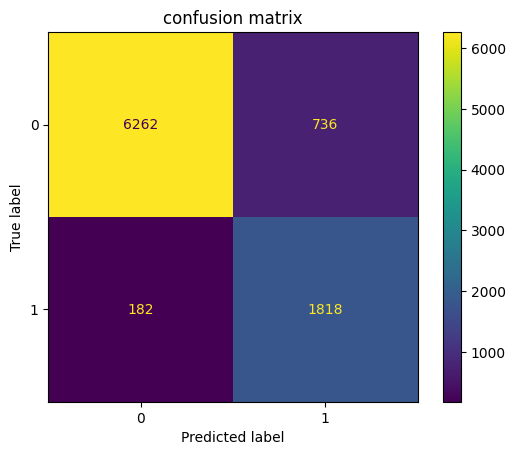

In [70]:
evaluate_final_model(best_model, X_test, y_test, le)

## análise dos resultados e erros
---

O modelo `RandomForest` otimizado alcançou uma **acurácia ponderada de 90%** no conjunto de teste. Analisando o `classification_report` e a `matriz de confusão`:

- **Performance na Classe Minoritária (1 - Aprovado):** O modelo obteve um `recall` de **0.91** para a classe 1. Isso significa que ele foi capaz de identificar corretamente 91% de todos os clientes que deveriam ter o empréstimo aprovado, o que é excelente para não perdermos bons clientes.

- **Tipos de Erro:**
    - **Falsos Positivos (Risco para o Negócio):** A matriz mostra que o modelo classificou **768** clientes como "Aprovados" quando na verdade eles eram da classe "Não Aprovado" (0). Este é o erro mais crítico, pois representa um **risco direto de inadimplência**.
    - **Falsos Negativos (Custo de Oportunidade):** O modelo classificou **176** clientes como "Não Aprovado" quando eles deveriam ser "Aprovados" (1). Este erro representa uma **perda de negócio** e um potencial cliente insatisfeito.

- **Trade-off:** A estratégia do modelo parece ser mais permissiva (alto `recall` para a classe 1), o que maximiza a captação de bons clientes ao custo de um risco maior de aprovar maus pagadores (`precisão` de **0.71** para a classe 1). Dependendo da aversão ao risco da empresa, poderíamos ajustar o `threshold` de decisão do modelo para sermos mais conservadores (aumentar a precisão em detrimento do recall).

## limitações do projeto
---

- **Features Ausentes:** O modelo foi treinado apenas com os dados disponíveis. Informações como histórico de pagamento de outras contas, número de dependentes ou valor de patrimônio poderiam enriquecer o poder preditivo.

- **Dados Estáticos:** O dataset representa uma "fotografia" do passado. O comportamento de crédito pode mudar com o cenário econômico, e o modelo pode ter sua performance degradada com o tempo (`model drift`), necessitando de monitoramento e retreino periódico.

- **Viés Potencial:** Não foi feita uma análise para verificar se o modelo apresenta algum viés e discrimina injustamente grupos específicos com base nas features existentes (ex: gênero, idade).

## próximos passos e melhorias
---

- **Engenharia de Features:** Criar features como: `loan_to_income_ratio` para tentar capturar relações mais complexas nos dados.

- **Testar Modelos Avançados:** Avaliar o desempenho de algoritmos como `XGBoost` e `LightGBM`.

- **Ajuste de Threshold:** Realizar um estudo para encontrar o ponto de corte (`threshold`) ótimo que minimize o custo financeiro para o negócio, balanceando Falsos Positivos e Falsos Negativos.